# **Mask Detection**

**1. Importación de librerias**

In [60]:
import cv2 
import numpy as np
import os
import random
from random import shuffle
import gc
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import math
from numpy import asarray
import seaborn as sns
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
#from keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import img_to_array
from keras.callbacks import ModelCheckpoint

**2. Descomprimir Dataset**

In [ ]:
!unzip train_mask.zip
!unzip train_nomask.zip

!unzip test_mask.zip
!unzip test_nomask.zip

**3. Dirreccionamiento del dataset**

In [63]:

train_mask = ['train_mask/{}'.format(i) for i in os.listdir('train_mask')]
train_nomask = ['train_nomask/{}'.format(i) for i in os.listdir('train_nomask')]

test_mask = ['test_mask/{}'.format(i) for i in os.listdir('test_nomask')]
test_nomask = ['test_nomask/{}'.format(i) for i in os.listdir('test_nomask')]

train = train_mask + train_nomask
test = test_mask + test_nomask

print ("Tamaño del DataSet de TRAIN", len(train))
print ("Tamaño del DataSet de TEST", len(test))


Tamaño del DataSet de TRAIN 1098
Tamaño del DataSet de TEST 590


**4. Dimensionamiento y escalado de las imagenes**

In [64]:
def PreProcesamiento(data_set):
  rows = 160
  cols = 160

  X = []
  Y = []

  for img in data_set:
    X.append(cv2.resize(cv2.imread(img, cv2.IMREAD_COLOR), (rows, cols), interpolation = cv2.INTER_CUBIC))
    if 'train_mask' in img:
      Y.append(1)
    elif 'train_nomask' in img:
      Y.append(0)
  
  return X, Y

In [65]:
x, y = PreProcesamiento(train)

**5. Se plotea algunas imagenes del dataset.**

Label: 1
Label: 1
Label: 1
Label: 1
Label: 1


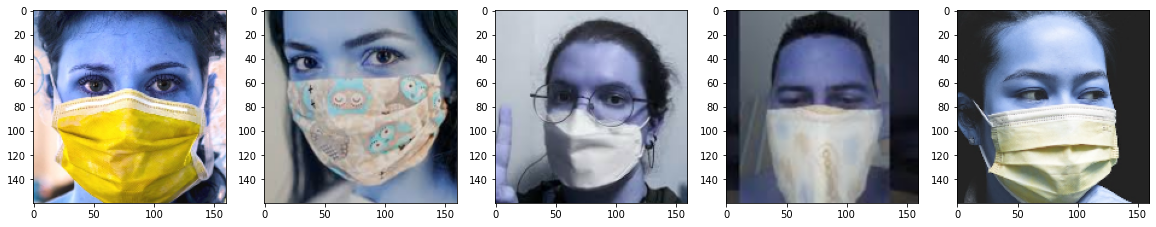

In [66]:
plt.figure(figsize = (20,10))
columns = 5
for i in range (columns):
  plt.subplot(5/columns+1,columns,i +1 )
  plt.imshow(x[i])
  print('Label:', y[i])

**6. Se grafica la forma de los features y labels**

La forma de los features de TRAIN son (1098, 160, 160, 3)
La forma de los labes de TRAIN son (1098,)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


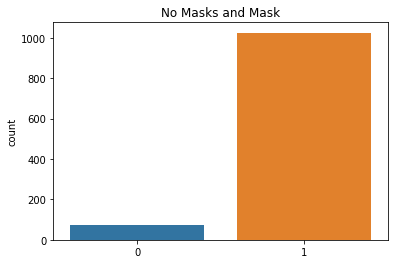

In [67]:
x = np.array(x)
y = np.array(y)
sns.countplot(y)
plt.title('No Masks and Mask')
print('La forma de los features de TRAIN son',x.shape)
print('La forma de los labes de TRAIN son',y.shape)

**7. Se divide el dataset para entrenamiento y validación**

In [68]:
#Partimos el dataset en datos de TRAIN y VALIDATION:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(x, y, test_size=0.2, random_state=2)
print('La forma de X_train es',X_train.shape)
print('La forma de X_val es',X_val.shape)
print('La forma de Y_train es',Y_train.shape)
print('La forma de Y_val es',Y_val.shape)
del x
del y
gc.collect()

La forma de X_train es (878, 160, 160, 3)
La forma de X_val es (220, 160, 160, 3)
La forma de Y_train es (878,)
La forma de Y_val es (220,)


13243

**8. Se implementar el ImageDataGenerator para ampliar el data de entrenamiento**

La clase ImageDataGenerator podemos usar algunas herramientas como; el escalado que en este caso lo uso para normalizar las imágenes y el validation_split para el entrenamiento.

In [69]:
train_datagenerator = ImageDataGenerator(rescale = 1./255, rotation_range = 40, width_shift_range = 0.2,
                                         height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2,
                                         horizontal_flip = True,)

val_datagenerator = ImageDataGenerator(rescale = 1./255)

train_gen = train_datagenerator.flow(X_train, Y_train, batch_size = 64)
val_gen = train_datagenerator.flow(X_val, Y_val, batch_size = 64)

**9. Modelo de la red Neuronal**

Creación del modelo

Se empleo:

- Cuatro capas convolucionales.
- Cuatro capas de MaxPooling.
- Una capa Flatten.
- Se implementa el Dropout.
- Dos capas densas.
- Activaciones relu y sigmoid.

In [75]:
n_train = len(X_train)
n_val = len(X_val)
batch_size = 110
learning_rate = 0.001

nb = math.ceil(len(X_train)/batch_size) # Nro de batches

model3 = Sequential([
    Conv2D(32, 3, activation='relu', padding='same', input_shape=(160,160,3)),
    MaxPool2D((2,2)),
    Conv2D(64, 3, activation='relu', padding='same'),
    MaxPool2D((2,2)),
    Conv2D(128, 3, activation='relu', padding='same'),
    MaxPool2D((2,2)),
    Conv2D(128, 3, activation='relu', padding='same'),
    MaxPool2D((2,2)),
    Flatten(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

#Definimos el tipo de checkpoint:
filepath="weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
#Definimos el optimizador y compilamos:
adam = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model3.compile(optimizer=adam, loss='binary_crossentropy', metrics=['acc'])

**10. Detalles del Modelo**

In [76]:
model3.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 160, 160, 32)      896       
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 80, 80, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_33 (Conv2D)          (None, 80, 80, 64)        18496     
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 40, 40, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 40, 40, 128)       73856     
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 20, 20, 128)     

**11. Entrenamiento del modelo.**

In [71]:
# Trainning
history3 = model3.fit_generator(train_gen, steps_per_epoch=n_train//batch_size, epochs=70, validation_data=val_gen,validation_steps=n_val//batch_size, callbacks=callbacks_list, verbose=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  



Epoch 1: val_acc improved from -inf to 0.93750, saving model to weights-improvement-01-0.94.hdf5

Epoch 2: val_acc did not improve from 0.93750

Epoch 3: val_acc did not improve from 0.93750

Epoch 4: val_acc did not improve from 0.93750

Epoch 5: val_acc did not improve from 0.93750

Epoch 6: val_acc improved from 0.93750 to 0.94531, saving model to weights-improvement-06-0.95.hdf5

Epoch 7: val_acc did not improve from 0.94531

Epoch 8: val_acc did not improve from 0.94531

Epoch 9: val_acc did not improve from 0.94531

Epoch 10: val_acc did not improve from 0.94531

Epoch 11: val_acc did not improve from 0.94531

Epoch 12: val_acc did not improve from 0.94531

Epoch 13: val_acc did not improve from 0.94531

Epoch 14: val_acc did not improve from 0.94531

Epoch 15: val_acc did not improve from 0.94531

Epoch 16: val_acc did not improve from 0.94531

Epoch 17: val_acc did not improve from 0.94531

Epoch 18: val_acc did not improve from 0.94531

Epoch 19: val_acc did not improve from 

**12. Grafica de resultados de loss y validación**

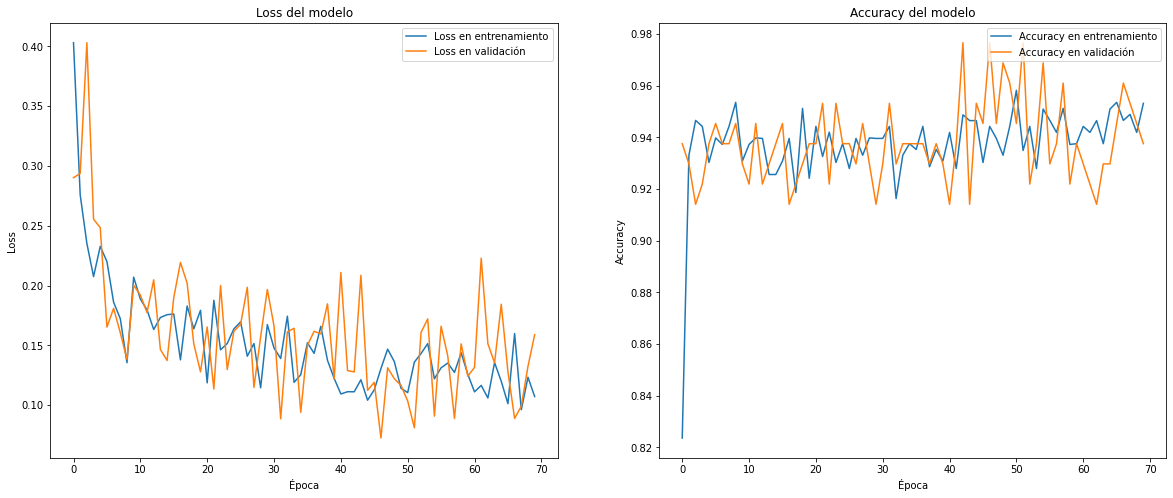

In [74]:
fig, (axL, axR) = plt.subplots(ncols=2, figsize=(20, 8))

axL.plot(history3.history['loss'], label="Loss en entrenamiento")
axL.plot(history3.history['val_loss'], label="Loss en validación")
axL.set_title('Loss del modelo')
axL.set_xlabel('Época')
axL.set_ylabel('Loss')
axL.legend(loc='upper right')

axR.plot(history3.history['acc'], label="Accuracy en entrenamiento")
axR.plot(history3.history['val_acc'], label="Accuracy en validación")
axR.set_title('Accuracy del modelo')
axR.set_xlabel('Época')
axR.set_ylabel('Accuracy')
axR.legend(loc='upper right')

plt.show()